In [1]:
from robust_mean import M_estimator
import numpy as np
import time
import matplotlib.pyplot as plt
from neurtu import timeit, delayed  

In [2]:
a = time.time()
mest = M_estimator(1)
X = np.random.normal(size=[1000,1000])
result = mest.estimate(X)
print(time.time()-a)

0.1528162956237793


In [3]:
print(np.linalg.norm(result))

0.9795568706509863


# 2D Illustration

In [4]:
N = 60 # Sample size
name = 'Huber'
epsilon = 0.1
center = [20, -1]

np.random.seed(2020)

# Sample dataset from a skewed distribution.
X = np.vstack([np.random.normal(size= [3*N//4,2]), 
              3+np.random.normal(size= [(N//4),2])])

# Contaminate with outliers
for f in np.arange(int(len(X)*epsilon)):
    X[f] = np.random.normal(size=2)+np.array(center)


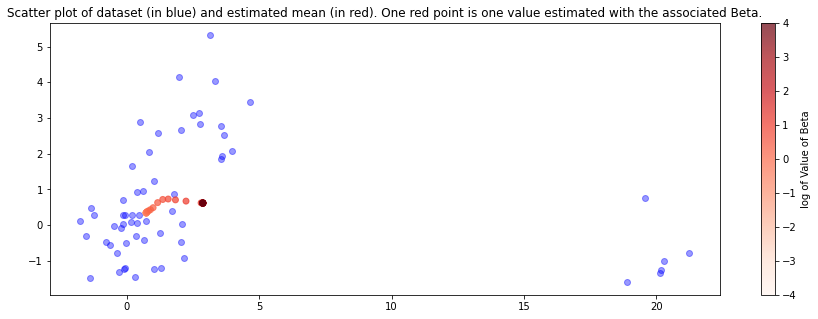

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

# define the estimators
estimated_values = []
for beta in np.logspace(-4,4):
    estimator = M_estimator(beta, name, p=4)
    estimated_values += [estimator.estimate(X)]

plt.scatter(X[:,0],X[:,1],alpha = 0.4, c='b')    
im = plt.scatter(np.array(estimated_values)[:,0], 
            np.array(estimated_values)[:,1], 
            cmap = plt.get_cmap('Reds'), 
            c = np.linspace(-4,4), alpha = 0.7)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('log of Value of Beta')


ax.set_title('Scatter plot of dataset (in blue) and estimated mean (in red).'
             ' One red point is one value estimated with the associated Beta.')

plt.show()

# Heavy tail illustration

In [6]:
def multivariate_t(m, df, n):
    d = len(m)
    x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),np.eye(d),size=n)
    res = m + z/np.sqrt(x)[:,np.newaxis] 
    return res

def projected_t(m, df, n):
    X = multivariate_t(m, df, n)
    X = np.abs(X)
    return X


def two_mode_t(m1, m2, df, n):
    X1 = multivariate_t(m1, df, n)
    X2 = multivariate_t(m2, df, n)
    binom = np.random.binomial(1, 0.7, size=n)
    res = np.zeros(X1.shape)
    res[binom == 1] = X1[binom == 1]
    res[binom == 0] = X2[binom == 0]
    return res

def pareto(df, n, d):
    return (np.random.pareto(df, size=[n,d])+1)

## Plot of a sample in 2D

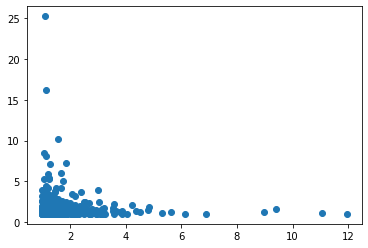

In [7]:
d = 2
X = pareto(3, 1000, d)
plt.scatter(X[:,0],X[:,1])

## Error of various mean estimators for growing dimension

### Finite Variance

In [9]:
n = 1000
Ds = np.arange(10, 1000, 50)
M = 25
res = np.zeros([M, len(Ds), 4])
for m in range(M):
    print('\r '+str(m), end='')
    for i, d in enumerate(Ds):
        X = pareto(2.1, n, d)
        mean = 2.1/1.1*np.ones(d)
        est_h = M_estimator(d**(1/2), "Huber")
        est_c = M_estimator(0.5*d**(1/2), "Catoni")
        est_p = M_estimator(0.7*d**(1/2), "Polynomial", p=3)
        res[m, i] = [np.linalg.norm(np.mean(X, axis=0)-mean),
                np.linalg.norm(est_h.estimate(X)-mean),
                np.linalg.norm(est_c.estimate(X)-mean),
                np.linalg.norm(est_p.estimate(X)-mean)]

 24

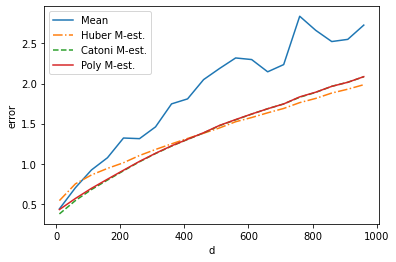

In [10]:
res = np.array(res)
resplot = np.mean(res, axis=0)
plt.plot(Ds, resplot[:,0], label='Mean')
plt.plot(Ds, resplot[:,1], label='Huber M-est.', linestyle='-.')
plt.plot(Ds, resplot[:,2], label='Catoni M-est.', linestyle='--')
plt.plot(Ds, resplot[:,3], label='Poly M-est.', linestyle='solid')
plt.xlabel('d')
plt.ylabel('error')
plt.legend()

### Infinite Variance

In [16]:
Ds = np.arange(10, 1000, 50)
res = np.zeros([M, len(Ds), 4])
from sklearn.ensemble import IsolationForest

def isol_est(x):
    clf = IsolationForest(contamination = 0.05).fit(X)
    inliers = clf.predict(X)
    return np.mean(X[inliers == 1], axis=0)

for m in range(M):
    print('\r '+str(m), end='')
    for i, d in enumerate(Ds):
        X = pareto(1.1, n, d)
        mean = 1.1/0.1*np.ones(d)
        est_h = M_estimator(d**(1/2), "Huber")
        est_c = M_estimator(0.5*d**(1/2), "Catoni")
        est_p = M_estimator(0.7*d**(1/2), "Polynomial", p=10)
        res[m, i] = [np.linalg.norm(np.mean(X, axis=0)-mean),
                np.linalg.norm(est_h.estimate(X)-mean),
                np.linalg.norm(est_c.estimate(X)-mean),
                np.linalg.norm(est_p.estimate(X)-mean)]

 24

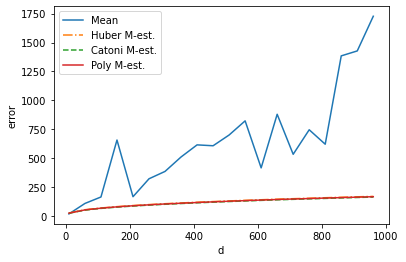

In [17]:
res = np.array(res)

resplot = np.mean(res, axis=0)
plt.plot(Ds, resplot[:,0], label='Mean')
plt.plot(Ds, resplot[:,1], label='Huber M-est.', linestyle='-.')
plt.plot(Ds, resplot[:,2], label='Catoni M-est.', linestyle='--')
plt.plot(Ds, resplot[:,3], label='Poly M-est.', linestyle='solid')

plt.xlabel('d')
plt.ylabel('error')
plt.legend()

## VS isolation forest + empirical mean, n=6000, d = 2000

In [18]:
n = 6000
d = 2000

In [28]:
def isol_mean(x):
    # compute the mean after an isolation forest pre-processing.
    clf = IsolationForest(contamination=0.1).fit(x)
    return np.mean(X[clf.predict(x)==1], axis=0)

### Finite Variance

In [29]:
mean = 2.1/1.1*np.ones(d)    
res = []
med = M_estimator(0, 'Huber')

for _ in range(M):
    X = pareto(2.1, n, d)
    mesth = M_estimator(3*np.sqrt(d), 'Huber')
    mestc = M_estimator(np.sqrt(d), 'Catoni')
    mestp = M_estimator(np.sqrt(d), 'Polynomial', p=2)


    res += [[
        np.linalg.norm(np.mean(X, axis=0)-mean),
        np.linalg.norm(np.median(X, axis=0)-mean),
        np.linalg.norm(mesth.estimate(X)-mean),
        np.linalg.norm(mestc.estimate(X)-mean),
        np.linalg.norm(mestp.estimate(X)-mean),
        np.linalg.norm(isol_est(X)-mean),
    ]]

In [30]:
res = np.array(res)
estimators = ['Mean', 'median', 'Huber', 'Catoni', 'Polynomial', 'Isolation Forest']
for i, est in enumerate(estimators):
    print(est+ ' has mean error %.2F and std error %.2f' %(np.mean(res[:,i]), np.std(res[:,i])))

Mean has mean error 1.75 and std error 0.19
median has mean error 23.17 and std error 0.01
Huber has mean error 1.32 and std error 0.02
Catoni has mean error 1.35 and std error 0.02
Polynomial has mean error 1.37 and std error 0.02
Isolation Forest has mean error 1.75 and std error 0.19


In [32]:
X = pareto(2.1, n, d)

# Benchmark the time needed to compute each algorithm.
bench = [
    delayed(
        M_estimator(1000*np.sqrt(d), name="Huber"),
        tags={"name": 'Huber'},
    ).estimate(X),
    delayed(
        M_estimator(0, name="Huber"),
        tags={"name": 'geo Med'},
    ).estimate(X),
    delayed(
        M_estimator(300*np.sqrt(d), name="Catoni"),
        tags={"name": 'Catoni'},
    ).estimate(X),
    delayed(
        M_estimator(1000*np.sqrt(d), p = 8, name="Polynomial"),
        tags={"name": 'Polynomial'},
    ).estimate(X),
    delayed(
        lambda x : np.mean(x, axis=0),
        tags={"name": 'Mean'},
    )(X),
    delayed(
        lambda x : np.median(x, axis=0),
        tags={"name": 'Median'},
    )(X),
    delayed(isol_mean,
        tags = {'name': 'isolation'}
    )(X)
]

bench = timeit(bench, repeat=3)
print(bench)

  0%|          | 0/21 [00:00<?, ?it/s]

            wall_time                     
                 mean        max       std
name                                      
Catoni       3.824839   4.043172  0.285254
Huber        1.985695   2.205263  0.213629
Mean         0.006077   0.006362  0.000285
Median       0.175509   0.181783  0.005549
Polynomial   2.861168   3.212091  0.323687
geo Med      2.661271   2.775447  0.105479
isolation   12.960636  13.768707  0.701481


### Infinite Variance

In [33]:
mean = 1.1/0.1*np.ones(d)    
res = []
med = M_estimator(0, 'Huber')

for _ in range(M):
    X = pareto(1.1, n, d)
    mesth = M_estimator(3*np.sqrt(d), 'Huber')
    mestc = M_estimator(np.sqrt(d), 'Catoni')
    mestp = M_estimator(np.sqrt(d), 'Polynomial', p=2)


    res += [[
        np.linalg.norm(np.mean(X, axis=0)-mean),
        np.linalg.norm(np.median(X, axis=0)-mean),
        np.linalg.norm(mesth.estimate(X)-mean),
        np.linalg.norm(mestc.estimate(X)-mean),
        np.linalg.norm(mestp.estimate(X)-mean),
        np.linalg.norm(isol_est(X)-mean),
    ]]

In [34]:
res = np.array(res)
estimators = ['Mean', 'median', 'Huber', 'Catoni', 'Polynomial', 'Isolation Forest']
for i, est in enumerate(estimators):
    print(est+ ' has mean error %.2F and std error %.2f' %(np.mean(res[:,i]), np.std(res[:,i])))

Mean has mean error 1109.81 and std error 1168.70
median has mean error 407.94 and std error 0.02
Huber has mean error 226.66 and std error 0.68
Catoni has mean error 216.73 and std error 0.69
Polynomial has mean error 203.08 and std error 1.27
Isolation Forest has mean error 1109.97 and std error 1168.91


In [35]:
X = pareto(1.1, n, d)
np.random.seed(42)
def isol_mean(x):
    # compute the mean after an isolation forest pre-processing.
    clf = IsolationForest(contamination=0.1).fit(x)
    return np.mean(X[clf.predict(x)==1], axis=0)

# Benchmark the time needed to compute each algorithm.
bench = [
    delayed(
        M_estimator(1000*np.sqrt(d), name="Huber"),
        tags={"name": 'Huber'},
    ).estimate(X),
    delayed(
        M_estimator(0, name="Huber"),
        tags={"name": 'geo Med'},
    ).estimate(X),
    delayed(
        M_estimator(300*np.sqrt(d), name="Catoni"),
        tags={"name": 'Catoni'},
    ).estimate(X),
    delayed(
        M_estimator(1000*np.sqrt(d), p = 8, name="Polynomial"),
        tags={"name": 'Polynomial'},
    ).estimate(X),
    delayed(
        lambda x : np.mean(x, axis=0),
        tags={"name": 'Mean'},
    )(X),
    delayed(
        lambda x : np.median(x, axis=0),
        tags={"name": 'Median'},
    )(X),
    delayed(isol_mean,
        tags = {'name': 'isolation'}
    )(X)
]

bench = timeit(bench, repeat=3)
print(bench)

  0%|          | 0/21 [00:00<?, ?it/s]

            wall_time                     
                 mean        max       std
name                                      
Catoni       3.519061   3.606187  0.086681
Huber        1.971952   2.045848  0.064595
Mean         0.005909   0.005992  0.000080
Median       0.171855   0.173745  0.001762
Polynomial   2.617636   2.656533  0.039375
geo Med      2.454505   2.576359  0.119865
isolation   12.912236  13.342797  0.409740
